# Contents

  * [Introduction](#Introduction)
  * [Setting up](#Setting-up)
  * [Loading and inspecting the data](#Loading-and-inspecting-the-data)
  * [Estimating tuning curves](#Estimating-tuning-curves)
  * [Bayesian decoding](#Bayesian-decoding)
  * [Application to decoding hippocampal "replay"](#Application-to-decoding-hippocampal-"replay")
  * [Exercises and mini-projects](#Exercises-and-mini-projects)

# Introduction

To support adaptive behavior, activity in the brain must correspond in some way to relevant sensory events and planned movements, combine many sources of information into multimodal percepts, and recall traces of past events to inform predictions about the future. In other words, neural activity must somehow *encode* relevant quantities. For instance, it can be demonstrated behaviorally that many animals use estimates of their location and head direction to navigate towards a goal. Where, and how, are these quantities represented in the brain? What are the neural circuits that can compute and update these signals? How do place and direction estimates contribute to which way to go? _Decoding_ approaches can help address such questions, and many more besides.

To develop an intuition for how decoding works, consider Hubel and Wiesel's demonstration that single cells in macaque V1 respond to bars of light not only within a particular region of visual space, but also with a specific orientation. Such cells are said to be tuned for orientation (of the bar) and a typical _tuning curve_ would therefore look like this:

![Tuning curve](images/hubel_wiesel_tc.png)

This tuning curve describes how the cell responds, on average, to different orientations of the stimulus. If the cell were to respond with the same firing rate across the range of stimulus orientations, then the cell is indifferent to this particular stimulus dimension: it does not encode it. However, because this cell clearly modulates its firing rate with stimulus orientation, it encodes, or represents (I use these terms interchangeably, but some disagree) this quantity in its activity.

We can turn this idea around and note that if orientation is encoded, this implies we can also decode the original stimulus from the cell's activity. For instance, if we noted that this cell was firing at a high rate, we would infer that the stimulus orientation is likely close to the cell's preferred direction. Note that this requires knowledge of the cell's tuning curve, and that based on one cell only, we are unlikely to be able to decode (or reconstruct, which means the same thing) the stimulus perfectly. The more general view is to say that the cell's activity provides a certain amount of information about the stimulus, or equivalently, that our (decoded) estimate of the stimulus is improved by taking the activity of this cell into account.

This module first explores some practical issues in estimating tuning curves of “place cells” recorded from the rat hippocampus. An introduction to a particular decoding method (Bayesian decoding) is followed by application to many simultaneously recorded place cells as a rat performs a T-maze task, described in [van der Meer et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hipo.22714/full).

# Setting up

To run this notebook, I used the following steps:
  * install MATLAB 2017a (email mvdm if you need a license)
  * install [Anaconda](https://www.continuum.io/downloads) (or use the Docker image which has it already installed)
  * intialize a Python 3.5 environment (`conda create --name py35 python=3.5 anaconda`)
  * enable the [MATLAB engine for Python](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html) (`cd "matlabroot\extern\engines\python"; python setup.py install`)
  * install [imatlab](https://github.com/imatlab/imatlab) (`python -m pip install imatlab; python -m imatlab install`)
  * you should now be able to open this notebook (`jupyter notebook` launches jupyter)

Next, we set the MATLAB environment to use the [vandermeerlab codebase](www.github.com/mvdm/vandermeerlab), and specify the location of the data folder used for this tutorial (`R042-2014-08-18`, from [van der Meer et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hipo.22714/full). To obtain the data, try [Datalad](http://datasets.datalad.org/?dir=/workshops/mind-2017) or see the download instructions [here](http://ctnsrv.uwaterloo.ca/vandermeerlab/doku.php?id=analysis:course-w16:week1#grab_a_data_session_from_the_vandermeerlab_data_vault) to access the mvdmlab server):

In [1]:
SET_GitHub_root = 'D:\My_Documents\GitHub'; % replace this with the location of your local GitHub root folder
SET_data_fd = 'D:\data\R042\R042-2013-08-18'; % replace this with the location of your local data folder

addpath(genpath(cat(2,SET_GitHub_root,'\vandermeerlab\code-matlab\shared'))); % warning is because this overloads the plot() function

imatlab_export_fig('print-png'); % set notebook output to be static png images

> In path (line 109)
  In addpath (line 88)


# Loading and inspecting the data

Next, we load the spike and position data (stored in `.t` and `.nvt` files respectively, as elaborated on [here](http://ctnsrv.uwaterloo.ca/vandermeerlab/doku.php?id=analysis:nsb2017:week2#data_files_overview), you may need to unzip the position data first):

In [2]:
cd(SET_data_fd);
 
please = []; please.load_questionable_cells = 1;
S = LoadSpikes(please); % `please` variable overrides default LoadSpikes() options
 
pos = LoadPos([]); % empty input [] causes LoadPos() to use default options

LoadSpikes: WARNING: loading questionable cells
LoadSpikes: Loading 107 files...
LoadPos.m: 100.00% of samples tracked.


The load_questionable_cells option in `LoadSpikes()` results in the loading of `._t` spike time files, in addition to the familiar `.t` files. The underscore extension indicates a cell with questionable isolation quality, likely contaminated with noise, spikes from other neurons, and/or missing spikes (see [here]() for more information on the spike sorting process inherent in extracellular recordings such as this one). In general, you do not want to use such questionable neurons to make claims about single neuron properties; however, for this analysis we are not concerned with properties of individual neurons. We are instead interested in the information present in a population of neurons, and for this we will take everything we can get!

Before looking at the data, we will first exclude the pre- and post-run segments of the data:

In [3]:
LoadExpKeys; % annotation file containing some basic information about this data session
S = restrict(S,ExpKeys.TimeOnTrack,ExpKeys.TimeOffTrack); % restrict to on-track data only
pos = restrict(pos,ExpKeys.TimeOnTrack,ExpKeys.TimeOffTrack);

Now we can plot the position data (location of the rat as it runs the maze, in gray), and the position of the rat when an example neuron fired a spike (in red):

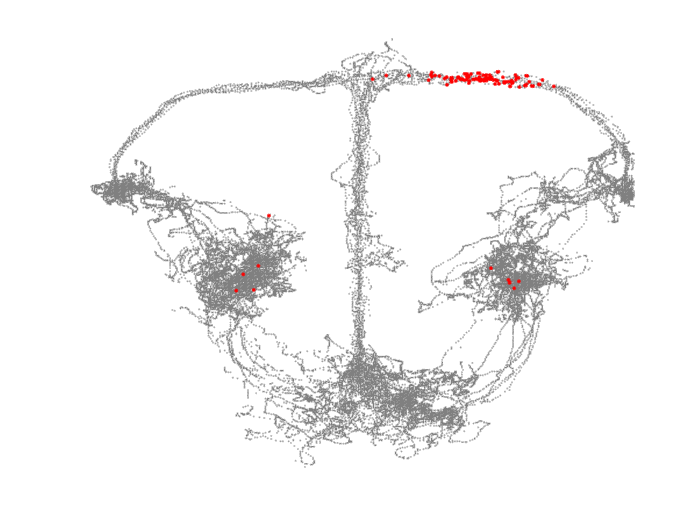

In [4]:
plot(getd(pos,'y'),getd(pos,'x'),'.','Color',[0.5 0.5 0.5],'MarkerSize',1); % note getd() gets data corresponding to a specific label (x and y here)
axis off; hold on;

iC = 7; % select cell 7 (out of 107 total)
spk_x = interp1(pos.tvec,getd(pos,'x'),S.t{iC},'linear');
spk_y = interp1(pos.tvec,getd(pos,'y'),S.t{iC},'linear');
 
h = plot(spk_y,spk_x,'.r'); axis tight;

Note the use of `interp1()` here: it finds the corresponding x and y values for each spike time using linear interpolation. This cell seems to have a place field just to the left of the choice point on the track (a T-maze). There are also a few spikes on the pedestals, where the rat rests in between runs on the track.

# Estimating tuning curves

This figure is a useful visualization of the raw data, but it is not a tuning curve, which captures the relationship between a variable of interest (e.g. position) to firing rate. A set of tuning curves can be thought of as an *encoding model* that specifies how the position variable is encoded by our population of place cells. As a first step to estmiating this model, we restrict our data to those times the rat is actually running on the track:

In [5]:
LoadMetadata; % loads experimenter-annotated file associated with each data session

% ENCoding variables: used for estimating tuning curves (encoding model)
ENC_S = restrict(S,metadata.taskvars.trial_iv); % trial_iv contains the start and end times of trials
ENC_pos = restrict(pos,metadata.taskvars.trial_iv);
 
% check for empties and remove
keep = ~cellfun(@isempty,ENC_S.t);
ENC_S = SelectTS([],ENC_S,keep);

% also set up DECoding variables for use later
DEC_S = SelectTS([],S,keep);

SelectTS: 107 ts in, 96 ts out
SelectTS: 107 ts in, 96 ts out


Now, we can compute tuning curves for each of our cells. The `TuningCurves()` function does this in three steps:
  * Compute an *occupancy* histogram (amount of time spent in each 2-D bin)
  * Compute a *spike* histogram (count number of spikes fired in each 2-D bin)
  * Compute firing rates by dividing the spike count by the occupancy

The below code plots the output of the third step for our example cell:

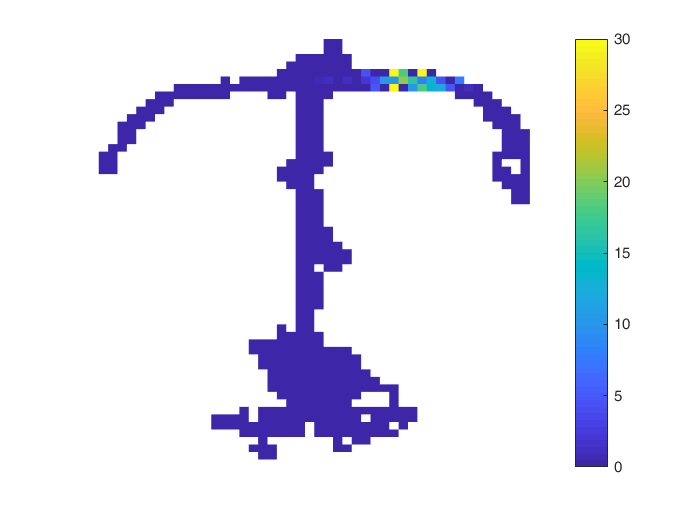

In [6]:
cfg_tc = [];
cfg_tc.minOcc = 1; % minimum occupancy (in seconds) for bin to be included
cfg_tc.binEdges{1} = 80:10:660; cfg_tc.binEdges{2} = 0:10:520; % bin edges (in camera pixels)
tc = TuningCurves(cfg_tc,ENC_S,ENC_pos);

pcolor(sq(tc.tc2D(iC,:,:))); % sq() squeezes 3-D matrix down to 2-D for plotting
shading flat; axis off; colorbar;

As can be seen from the plot above, the (arbitrary) binning results in a noisy-looking tuning curve. As shown in [van der Meer et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hipo.22714/full) applying some judicious smoothing can increase decoding accuracy substantially. This smoothing is kind of a hack, and can be viewed as an approximation of a more principled estimation process that starts with a prior on the likely shape of single cell tuning curves which is then updated using the encoding data. For now, we'll just do what works:

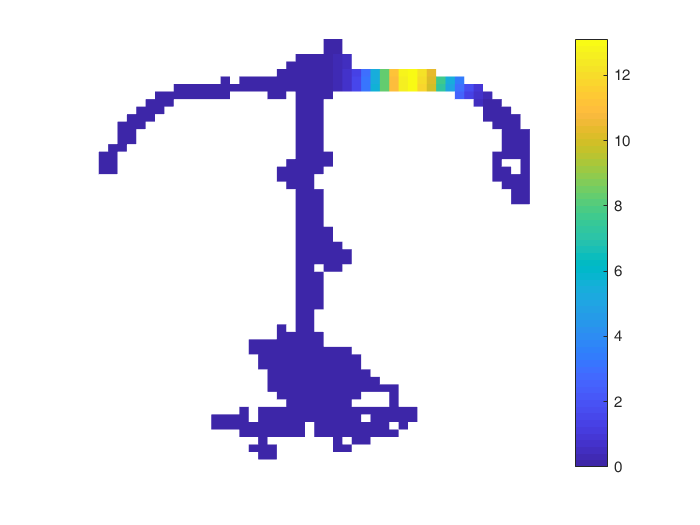

In [7]:
cfg_tc.smoothingKernel = gausskernel([4 4],2); % Gaussian kernel of 4x4 pixels, SD of 2 pixels (note this should sum to 1)
tc = TuningCurves(cfg_tc,ENC_S,ENC_pos);

pcolor(sq(tc.tc2D(iC,:,:))); shading flat; axis off; colorbar

You can inspect the tuning curves of all cells as follows:

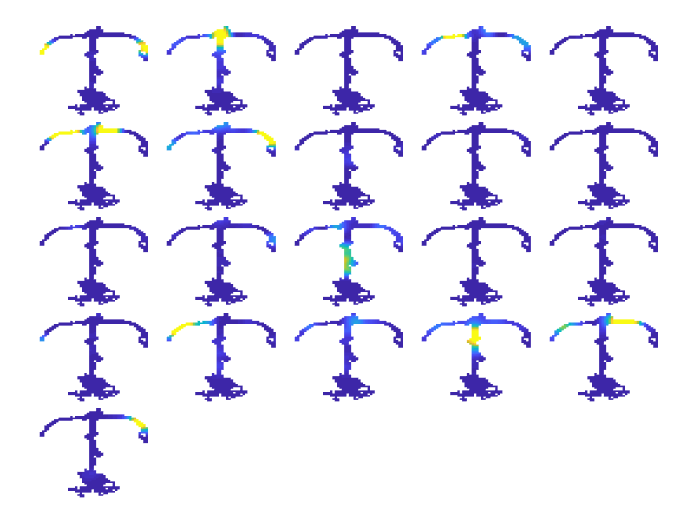

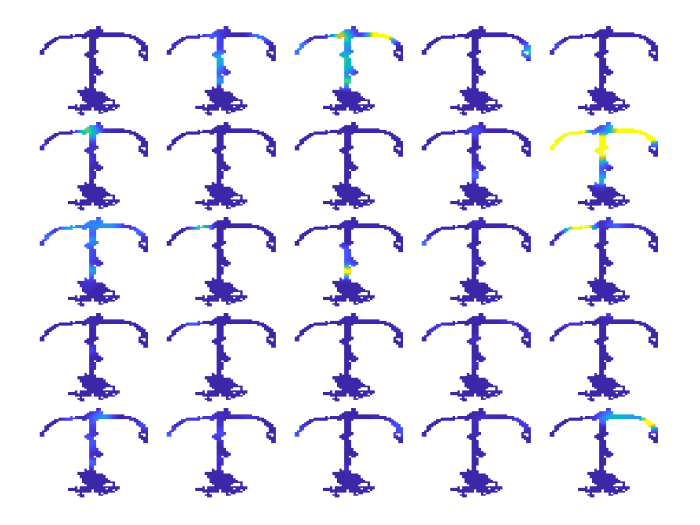

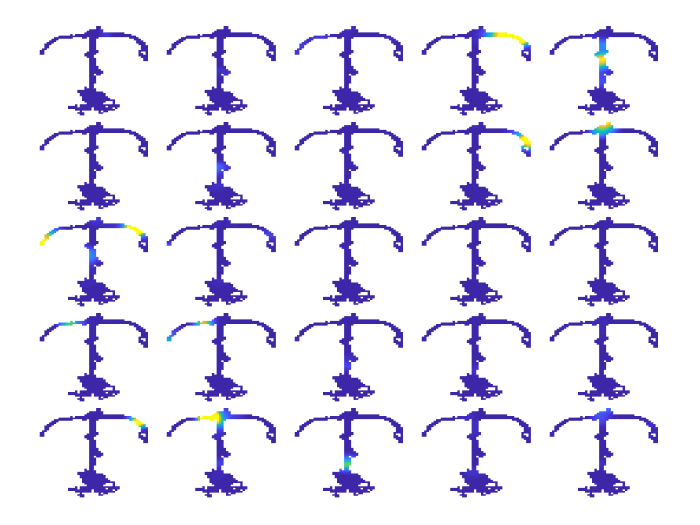

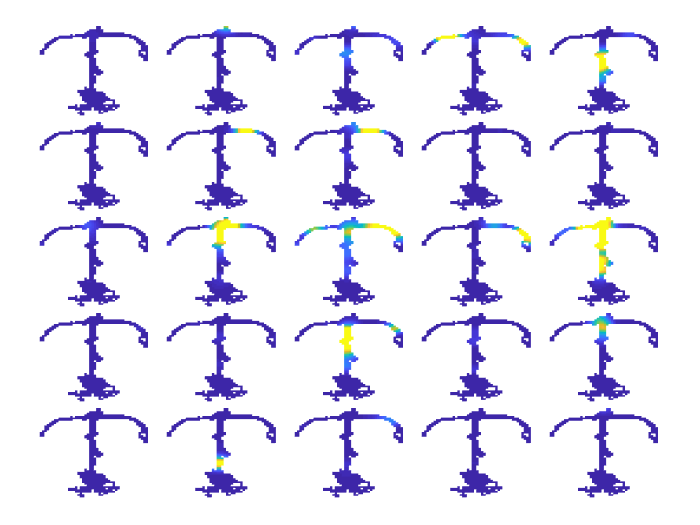

In [8]:
ppf = 25; % plots per figure
for iC = 1:length(ENC_S.t)
    nFigure = ceil(iC/ppf); figure(nFigure);
    subtightplot(5,5,iC-(nFigure-1)*ppf);
    
    pcolor(sq(tc.tc2D(iC,:,:))); shading flat; axis off;
    caxis([0 10]); % set color axis from 0 to 10 Hz
 
end

You will see a some textbook “place cells” with a clearly defined single place field. There are also cells with other firing patterns.

This notebook computes tuning curves for location, but the idea is of course more general. For continuous variables in particular, it is a natural and powerful way to describe the relationship between two quantities – spikes and location in this case, but there is no reason why you couldn't do something like pupil diameter as a function of arm reaching direction, for instance!

Note: The `tc` struct returned by `TuningCurves()` contains a number of other fields in addition to the actual tuning curves plotted above. In a nutshell, these fields exist to speed up the decoding computations later, by only storing firing rates for bins with sufficient sampling (occupancy): as you can see from the tuning curves above, this is true for only a small subset of the full grid. The `tc.good_idx` variable strores the indices (into the 2-D grid) of those bins, and `tc.tc` contains tuning curves in this reduced format (i.e. is of size [nCells x length(good_idx)]). 

# Bayesian decoding

As noted in the introduction above, given that we have neurons whose activity seems to encode some stimulus variable (location in this case, as evident from the tuning curves above), we can attempt to decode that variable based on the neurons' time-varying activity.

A popular approach to doing this is “one-step Bayesian decoding”, illustrated in this figure (from <a href="http://www.cell.com/neuron/abstract/S0896-6273(10)00507-6">van der Meer et al. 2010</a>):

![Decoding schematic](images/mvdm_yorkfieldtrip13.png)

For this particular experiment, the goal of decoding is to recover the location of the rat, given neural activity in some time window. More formally, we wish to know $P(\mathbf{x}|\mathbf{n})$, the probability of the rat being at each possible location $x_i$ ($\mathbf{x}$ in vector notation, to indicate that there are many possible locations) given a vector of spike counts $\mathbf{n}$.

If $P(\mathbf{x}|\mathbf{n})$ (the "posterior") is the same for every location bin $x_i$ (i.e. is uniform), that means all locations are equally likely and we don't have a good guess; in contrast, if most of the $x_i$ are zero and a small number have a high probability, that means we are confident predicting the most likely location. Of course, there is no guarantee that our decoded estimate will agree with the actual location; we will test this later on.

So how can we obtain $P(\mathbf{x}|\mathbf{n})$? We can start with Bayes' rule:

$P(\mathbf{x}|\mathbf{n})P(\mathbf{n}) = P(\mathbf{n}|\mathbf{x})P(\mathbf{x})$

If you have not come across Bayes' rule before, or the above equation looks mysterious to you, review the gentle intro by linked to at the top of the page. In general, it provides a quantitative way to update prior beliefs in the face of new evidence.

The key quantity to estimate is $P(\mathbf{n}|\mathbf{x})$, the probability of observing $n$ spikes in a given time window when the rat is at location $x$. At the basis of estimating this probability (the "likelihood" or evidence) lies the tuning curve: this tells us the _average_ firing rate at each location. We need a way to convert a given number of spikes -- whatever we observe in the current time window for which we are trying to decode activity, 3 spikes for cell 1 in the figure above -- to a probability. In other words, what is the probability of observing 3 spikes in a 250ms time window, given that for this location the cell fires, say at 5Hz on average?

A convenient answer is to assume that the spike counts follow a Poisson distribution. Assuming this enables us to assign a probability to each possible spike count for a mean firing rate given by the tuning curve. For instance, here are the probabilities of observing different numbers of spikes $k$ (on the horizontal axis) for four different means ($\lambda = $1, 4 and 10):

![Poisson distro](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/500px-Poisson_pmf.svg.png)

In general, from the [definition of the Poisson distribution](http://en.wikipedia.org/wiki/Poisson_distribution), it follows that

$P(n_i|\mathbf{x}) = \frac{(\tau f_i(\mathbf{x}))^{n_i}}{n_i!} e^{-\tau f_i (x)}$

$f_i(\mathbf{x})$ is the average firing rate of neuron $i$ over $x$ (i.e. the tuning curve for position), $n_i$ is the number of spikes emitted by neuron $i$ in the current time window, and $\tau$ is the size of the time window used. Thus, $\tau f_i(\mathbf{x})$ is the mean number of spikes we expect from neuron $i$ in a window of size $\tau$; the Poisson distribution describes how likely it is that we observe the actual number of spikes $n_i$ given this expectation.

In reality, place cell spike counts are [typically not Poisson-distributed](http://www.ncbi.nlm.nih.gov/pubmed/9501237) so this is clearly a simplifying assumption. There are many other, more sophisticated approaches for the estimation of $P(n_i|\mathbf{x})$ (see for instance [Paninski et al. 2007](http://www.ncbi.nlm.nih.gov/pubmed/17925266)) but this basic method works well for many applications.

The above equation gives the probability of observing $n$ spikes for a given average firing rate for a single neuron. How can we combine information across neurons? Again we take the simplest possible approach and assume that the spike count probabilities for different neurons are independent. This allows us to simply multiply the probabilities together to give:

$P(\mathbf{n}|\mathbf{x}) = \prod_{i = 1}^{N} \frac{(\tau f_i(\mathbf{x}))^{n_i}}{n_i!}
e^{-\tau f_i (x)}$

An analogy here is simply to ask: if the probability of a coin coming up heads is $0.5$, what is the probability of two coints, flipped simultaneously, coming up heads? If the coins are independent then this is simply $0.5*0.5$.

Combining the above with Bayes' rule, and rearranging a bit, gives

$P(\mathbf{x}|\mathbf{n}) = C(\tau,\mathbf{n}) P(\mathbf{x}) (\prod_{i = 1}^{N} f_i(\mathbf{x})^{n_i}) \: e (-\tau \sum_{i = 1}^N f_i(\mathbf{x}))$

This is more easily evaluated in vectorized MATLAB code. $C(\tau,\mathbf{n})$ is a normalization factor which we simply set to guarantee $\sum_x P(\mathbf{x}|\mathbf{n}) = 1$ (Zhang et al. 1998). For now, we assume that $P(\mathbf{x})$ (the "prior") is uniform, that is, we have no prior information about the location of the rat and let our estimate be completely determined by the likelihood.

The tuning curves take care of the $f_i(x)$ term in the decoding equations. Next, we need to get $\mathbf{n}$, the spike counts.

## Obtaining the Q-matrix

This “Q-matrix” is of size [nCells x nTimeBins] and contains the spike count for each neuron in a given time bin:

WARNING in MakeQfromS: unrecognized config field(s) binsize, tvec_centers


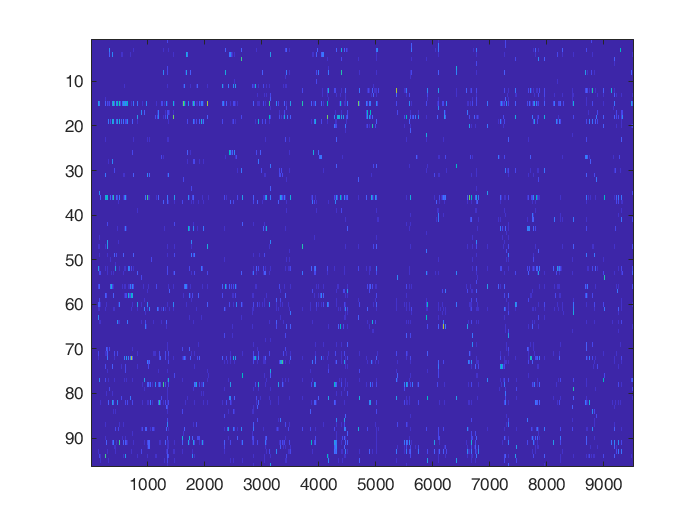

In [9]:
cfg_Q = [];
cfg_Q.binsize = 0.25;
cfg_Q.tvec_edges = metadata.taskvars.trial_iv.tstart(1):cfg_Q.binsize:metadata.taskvars.trial_iv.tend(end);
cfg_Q.tvec_centers = cfg_Q.tvec_edges(1:end-1)+cfg_Q.binsize/2;

Q = MakeQfromS(cfg_Q,DEC_S);
imagesc(Q.data);

Each column of this matrix is a vector of spike counts ($\mathbf{n}$ in the section above). You can use the interactive features in the [plotly](https://plot.ly/~mvdm/8/) version to zoom in to specific columns in the above plot.

Note that this type of matrix is shared by many different kinds of data in neuroscience -- this one contains binned spike counts, but a similar matrix can be constructed for spike density functions (firing rates), BOLD signals for voxels measured by fMRI, calcium levels from fluorescent microscopy, and so on. Analyses such as representational similarity analysis, functional and effective connectivity, discovery of network structure (hubs, ensembles, cliques, etc.) take a matrix of this type as a starting point. 

## Running the decoding algorithm

For the purposes of this tutorial, this matrix completes the set of ingredients required to perform decoding. Although the codebase provides configurable [wrapper functions](https://github.com/vandermeerlab/vandermeerlab/tree/b0d349b1f78b47b272f26c618e0235c97ef40f4a/code-matlab/shared/proc/Decoding) for this, a minimal version of the raw code follows below so you can see how it works:

In [10]:
Q = restrict(Q,metadata.taskvars.trial_iv); % for speed, only decode trials of running on track

nBins = length(tc.good_idx);
occUniform = repmat(1/nBins,[nBins 1]); % prior over locations, P(x) in section above

nActiveNeurons = sum(Q.data > 0);
 
len = length(Q.tvec);
p = nan(length(Q.tvec),nBins); % this variable will store the posterior
for iB = 1:nBins % loop over space bins (x_i)
    tempProd = nansum(log(repmat(tc.tc(:,iB),1,len).^Q.data)); % these 3 lines implement the actual decoding computation
    tempSum = exp(-cfg_Q.binsize*nansum(tc.tc(:,iB)',2)); % compare to the equations above!
    p(:,iB) = exp(tempProd)*tempSum*occUniform(iB);
end
 
p = p./repmat(sum(p,2),1,nBins); % renormalize to 1 total probability
p(nActiveNeurons < 1,:) = 0; % ignore time bins with no activity

Now we want to display the results. Before we do so, we should convert the rat's actual position into our binned form, so that we can compare it to the decoded estimate:

In [11]:
xBinned = interp1(ENC_pos.tvec,tc.pos_idx(:,1),Q.tvec);
yBinned = interp1(ENC_pos.tvec,tc.pos_idx(:,2),Q.tvec);

## Visualizing decoder output

Now we can visualize the decoding, shown here as a movie (see below for the code):


<iframe width="560" height="315" src="https://www.youtube.com/embed/ogEUDPrNpwc" frameborder="0" allowfullscreen></iframe>

You can see the rat's true location, rendered as a white circle, moving around -- initially hanging around at the base of the maze, and then running up the stem to one of the reward locations at the end of the maze arms (food on the left, water on the right). The output of the decoder is plotted in pseudocolor -- blue colors indicate low decoding probability, and green/yellow/red indicate progressively higher probability. You should see that as the rat runs along the track, the decoder output tends to follow the rat's true location. In other words, based on neural activity in a given time bin, we can infer the location of the rat.

(Note there are some segments of the data for which no decoding output appears; this is due to restriction of the data to runs on the track only.)

To generate the above movie in MATLAB, execute the code below with the plotting commands uncommented:

In [12]:
dec_err = nan(length(Q.tvec),1); % variable to keep track of decoding error
% h = figure; set(h,'Position',[100 100 640 480]); % fix position of figure to help encoding of movie for export later

for iT = 1:length(Q.tvec) % loop over time bins
    
    toPlot = nan(tc.nBins{1},tc.nBins{2}); % initialize empty 2-D grid
    toPlot(tc.good_idx) = p(iT,:); % assign decoding probabilities to "good" bins
 
    % cla; pcolor(toPlot); axis xy; hold on; caxis([0 0.5]); shading flat; axis off; % plot decoding output
    % hold on; plot(yBinned(iT),xBinned(iT),'ow','MarkerSize',15); % overlay actual position
 
    % get x and y coordinates of location with largest decoding probability ("maximum a posteriori" or MAP)
    [~,idx] = max(toPlot(:)); [x_map,y_map] = ind2sub(size(toPlot),idx);
    % plot(y_map,x_map,'g*','MarkerSize',5); % plot MAP location
 
    % compute error: distance between actual position and MAP position
    if nActiveNeurons(iT) > 0, dec_err(iT) = sqrt((yBinned(iT)-y_map).^2+(xBinned(iT)-x_map).^2); end
 
    % h = title(sprintf('t %.2f, nCells %d, dist %.2f',Q.tvec(iT),nActiveNeurons(iT),dec_err(iT))); 
    % if nActiveNeurons(iT) == 0, set(h,'Color',[1 0 0]); else, set(h,'Color',[0 0 0]); end
    
    % pause(0.1); drawnow;
    % f(iT) = getframe(gcf); % uncomment this if exporting to video file
   
end

## Quantifying decoding error

The above movie gives a useful visual impression of what the decoder output looks like, and that it roughly seems to track the rat's position. A more systematic approach to evaluating the performance of the decoder is to plot the _error_, i.e. the distance between the actual and decoded positions. If you haven't done so already, run the cell above to compute it. Then, the following will plot the error as a function of space:

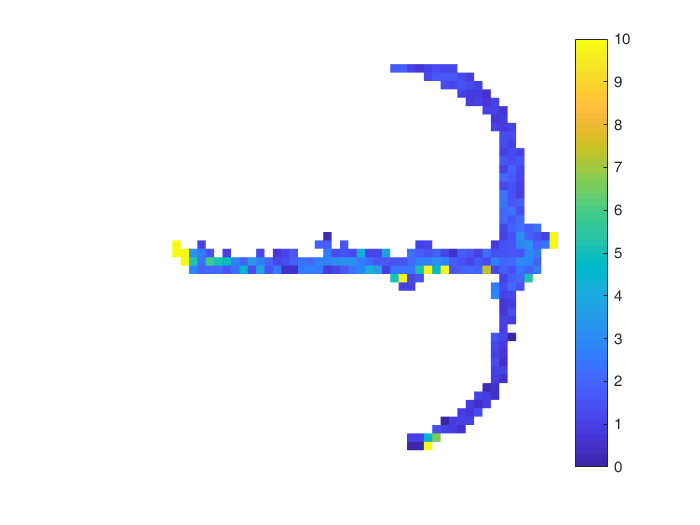

In [13]:
dec_err_tsd = tsd(Q.tvec,dec_err); % create timestamped data struct for decoding error computed above

cfg = []; cfg.y_edges = cfg_tc.binEdges{2}; cfg.x_edges = cfg_tc.binEdges{1};
space_err = TSDbySpace(cfg,ENC_pos,dec_err_tsd);
 
pcolor(space_err); shading flat; axis off; colorbar; caxis([0 10]);

It looks like the decoding error is on average larger on the central stem, compared to the arms of the maze. Then there are some outlier points with high (>10 pixels) decoding error.

☛ What could be some reasons for this? Can you think of ways to test your suggestions?

## Advanced topic: cross-validation in decoding

So far, we have been using the same data -- runs on the track -- to estimate our encoding model (tuning curves) and to apply our decoder to. This "tautological" approach is of limited value because it does not do a good job of testing how well our decoder works on data that was not used to construct it. As a result, there is the risk of _overfitting_: capturing idiosyncratic features of data which do not generalize. A common approach to prevent overfitting is to use cross-validation, which for our data set can be visualized like this (from [van der Meer et al. 2017](http://onlinelibrary.wiley.com/doi/10.1002/hipo.22714/full)):

<img src="images/decSchemes.png" width=600px>

Implementing such cross-validation schemes here would entail using different `restrict()` calls to make non-overlapping `ENC_S` and `DEC_S` sets of data, decoding `DEC_S` based on tuning curves obtained from `ENC_S`. [van der Meer et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hipo.22714/full) show that the distribution of decoding error across the track can differ substantially between tautological and cross-validated decoding, as illustrated here:

<img src="images/decQuantify_spaceG.png" width=600px>

This is a methodologically important observation, because these distributions are the null hypothesis of what we expect when decoding internally generated activity such as occurs during memory recall and planning. For instance, suppose you are interested in what a subject recalls about some prior experience with the task. Perhaps you find a tendency for the subject to replay trajectories that cross the decision point of the T-maze -- a potentially exciting result, because such preferential replay of decision points is what has been shown to be effective in off-line reinforcement learning. However, the above figure provides an alternative, less interesting explanation: your ability to decode locations at the edges of the track is simply lower than for the center of the track! In other words, such an observation is in fact consistent with the non-uniform null hypothesis obtained from cross-validated decoding accuracy.

# Application to decoding hippocampal "replay"

Now that we have validated our decoder on data where we know the correct answer, we can apply it to _internally generated activity_ that occurs in the absence of overt behavior. The rodent and human hippocampus is known to "replay" experience during wakeful rest and sleep ([Wilson and McNaughton 1994)](https://www.ncbi.nlm.nih.gov/pubmed/8036517); [Pezzulo et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/28548460)), although this term has become misleading in the light of accumulating evidence that internally generated sequences in the hippocampus (and declarative memory more generally) are _constructive_, i.e. not limited to literal repeats of prior experience, but including shortcuts and trajectories towards a goal ([Gupta et al. 2010](https://www.ncbi.nlm.nih.gov/pubmed/20223204); [Pfeiffer and Foster 2013](https://www.ncbi.nlm.nih.gov/pubmed/23594744)).

Hippocampal replay is known to occur during so-called _sharp wave-ripple complexes_, SWRs for short, which are network events visible in the local field potential that reflect the sudden, transient and highly synchronous activity of a large number of hippocampal neurons. Let's find some in our data! To make visualization and analysis easier, we will linearize the 2-D position data into 1-D "left" and "right" trials:

In [14]:
expCond(1).label = 'left'; % this is a T-maze, we are interested in 'left' and 'right' trials
expCond(2).label = 'right'; % these are just labels we can make up here to keep track of which condition means what

expCond(1).t = metadata.taskvars.trial_iv_L; % previously stored trial start and end times for left trials
expCond(2).t = metadata.taskvars.trial_iv_R; 

expCond(1).coord = metadata.coord.coordL; % previously user input idealized linear track, used for linearization
expCond(2).coord = metadata.coord.coordR; % note, this is in units of "camera pixels", not cm

expCond(1).S = S; expCond(2).S = S;

% linearize paths (snap x,y position samples to nearest point on experimenter-drawn idealized track)
nCond = length(expCond);
for iCond = 1:nCond
   
    cfg_linpos = []; cfg_linpos.Coord = expCond(iCond).coord;
    expCond(iCond).linpos = LinearizePos(cfg_linpos,pos);
   
end

LinearizePos: linearizing data...
LinearizePos: linearizing data...


Next, we restrict the data to the corresponding trials, and only those times when the rat is running:

In [15]:
% find intervals where rat is running
spd = getLinSpd([],pos); % get speed (in "camera pixels per second")

cfg_spd = []; cfg_spd.method = 'raw'; cfg_spd.threshold = 10; 
run_iv = TSDtoIV(cfg_spd,spd); % intervals with speed above 10 pix/s

% restrict (linearized) position data and spike data to desired intervals
for iCond = 1:nCond
   
    fh = @(x) restrict(x,run_iv); % function to restrict input to run times only
    expCond(iCond) = structfunS(fh,expCond(iCond),{'S','linpos'}); % apply function to S and linpos fields of input
    
    fh = @(x) restrict(x,expCond(iCond).t); % function to restrict input to specific trials (left/right)
    expCond(iCond) = structfunS(fh,expCond(iCond),{'S','linpos'});
    
end

getLinSpd: calculating linear speed from position data


TSDtoIV: 857 intervals found.


............................!............................!

Now we can compute our tuning curves, as before, except now they are 1-D rather than 2-D:

In [16]:
for iCond = 1:nCond
    
    cfg_tc = []; % use the defaults
    expCond(iCond).tc = TuningCurves(cfg_tc,expCond(iCond).S,expCond(iCond).linpos); % note, same function as above
    
end

To help with visualization, we are going to apply a simple (and arbitrary) rule for which of these tuning curves have a defined "place field" and get the location of that field:

In [17]:
for iCond = 1:nCond
    
    expCond(iCond).fields = DetectPlaceCells1D([],expCond(iCond).tc.tc); % function to detect place fields and their location
    
end

We also want to load a local field potential, because it will be useful in detecting candidate replay events:

In [18]:
cfg = []; cfg.fc = ExpKeys.goodSWR(1); % note use of experimenter-annotated data file to use
lfp = LoadCSC(cfg); lfp = decimate_tsd([],lfp); % subsample LFP data (to 500 Hz) to speed up plotting

LoadCSC: Loading 1 file(s)...
LoadCSC: R042-2013-08-18-CSC11a.ncs 0/17193 bad blocks found (0.00%).


Now, we can plot the data using the fabulous `MultiRaster()` function:

SelectTS: 107 ts in, 26 ts out
SelectTS: 107 ts in, 35 ts out


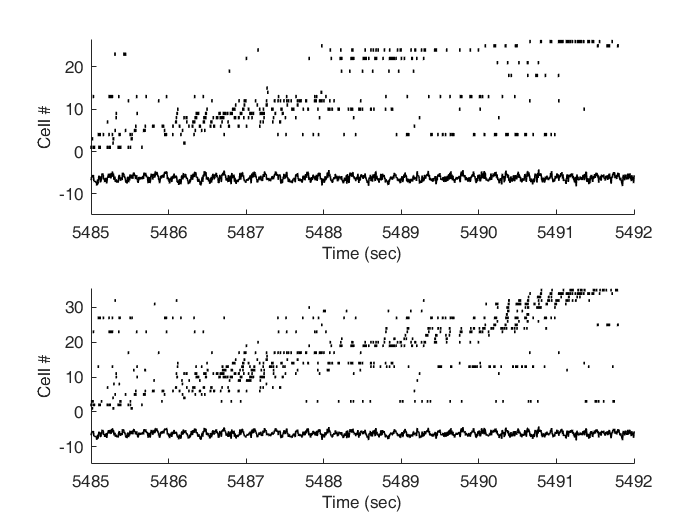

In [19]:
fh = figure('KeyPressFcn',@navigate); % enable keyboard shortcuts for figure navigation (see help navigate or press h for instructions)
for iCond = 1:nCond
    ax(iCond) = subplot(2,1,iCond); % set up separate subplots for left and right place fields
    
    S_temp = SelectTS([],S,expCond(iCond).fields.template_idx); % template_idx contains ordered place cells
    
    cfg_mr = []; cfg_mr.openNewFig = 0; cfg_mr.lfp = lfp;
    MultiRaster(cfg_mr,S_temp);
    
    xlim([5485 5492]); % zoom in on specific time interval of interest
end
linkaxes(ax,'x')

The figure shows two separate panels whose time axis is linked. Each panel (top for cells with place fields on "left" trials, bottom for cells with fields on "right" trials) contains a rasterplot with tickmarks indicating spike times. Each row represents a cell. The panels also have the same local field potential, plotted underneath the raster.

The time interval shown corresponds to a single trial -- a run from the base of the maze to the end of the right arm. The cells have been ordered according to the location of their place field on the track, as apparent from the (mostly) ordered progression in which the cells are activated in time, starting with the cells at the bottom and ending with cells at the top. You can tell that this is a _right_ trial because the ordered progression of cell activation breaks down at some point for the top plot (corresponding to left trials) but continues past the midpoint for the bottom (right) plot.

A number of interesting features of hippocampal activity are apparent. First, the activity of individual cells is strongly rhythmic: given a spike at a certain time, more spikes are likely to occur approximately 100-125 ms later. The local field potential shows a similar rhythmicity in the form of an ~8 Hz ("theta") oscillation. Closer inspection reveals that place cell spikes are not locked to a specific phase of the theta rhythm, but _precess_ systematically (fire at progressively earlier phases) as the rat traverses the place field. (If you are running this in MATLAB, `MultiRaster()` enables keypresses to navigate and zoom in; press `h` to see the available commands.) At the ensemble level, coordinated phase precession results in _theta sequences_, which manifest as repeating diagonals in the plot, evident for instance between 5490.5 and 5491 s.

The theta rhythm and sustained activation of place cells is characteristic of an animal that is moving and/or attentive. Hippocampal activity looks quite different during wakeful rest:

SelectTS: 107 ts in, 26 ts out
SelectTS: 107 ts in, 35 ts out


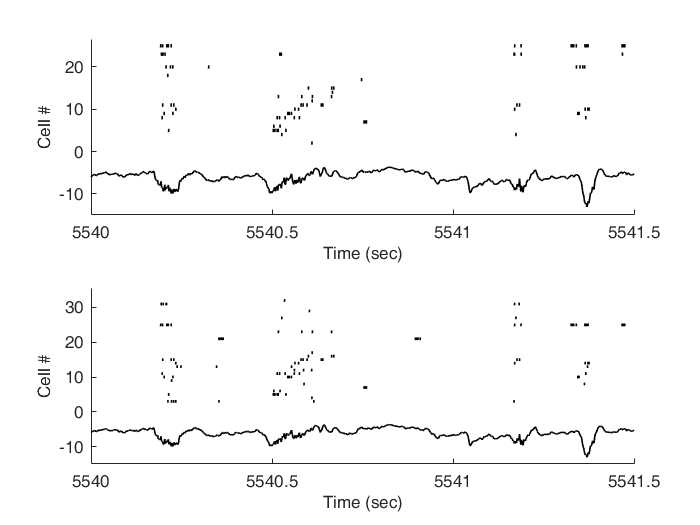

In [20]:
fh = figure('KeyPressFcn',@navigate); % enable keyboard shortcuts for figure navigation (see help navigate or press h for instructions)
for iCond = 1:nCond
    ax(iCond) = subplot(2,1,iCond); % set up separate subplots for left and right place fields
    
    S_temp = SelectTS([],S,expCond(iCond).fields.template_idx); % template_idx contains ordered place cells
    
    cfg_mr = []; cfg_mr.openNewFig = 0; cfg_mr.lfp = lfp;
    MultiRaster(cfg_mr,S_temp);
    
    xlim([5540 5541.5]); % different time
end
linkaxes(ax,'x')

The LFP no longer exhibits a sustained theta rhythm. It appears arrhythmic, but is periodically interrupted by large slow deflections, "sharp waves", that coincide with a fast ~150-200 Hz "ripple". These sharp wave-ripple complexes (SWRs) are associated with synchronous activity in a large number of place cells, which tend to be quiescent otherwise.

Four clear SWR events are visible in the above plot. The second one (around time 5540.5) appears to have place cells active in the same order (particularly apparent in the top panel) as they were active during run -- an example of replay!

The _content_ of replay, i.e. what actual or constructed experience it best corresponds to, is a quantity of psychological interest. How does an animal segment a continuous environment or experience into discrete chunks? Are certain aspects of experience preferentially replayed? Can subsequent choices be predicted from replay content? To address such questions we need a systematic way of identifying candidate replay events, determining whether they reflect specific content (decoding), and summarizing that content. This can be accomplished in the following steps:
  - Detect candidate replay events based on LFP properties, multi-unit activity, and behavioral variables such as the subject being stationary. These steps typically involve thresholding to obtain intervals of interest, followed by _set operations_ on these intervals (e.g. keep the intersection of intervals that are above threshold in ripple power and below threshold in running speed)
  - Score candidate replay events based on some significance or "sequence-ness" criterion, for which a number of approaches have been used, broadly falling into two different categories: (1) spike-based methods, which test for a correlation between the temporal order in which different cells fire and where those cells have place fields, and (2) decoding-based methods, which test for a dependency between time and the decoded location, such as indicated by a significant linear regression fit. Events that pass this criterion are used for further analysis.
  - Classifying significant replay events according to where they decode to, experimental conditions, et cetera. For the T-maze data set used in this tutorial, one obvious question is to ask if replay content is biased towards the left or right arm of the maze. One simple way to determine this would be to count the number of significant replays on either side and compare the observed count to an equal number; however, as pointed out in the section above, a better null hypothesis takes into account a decoder's ability to correctly decode location on both sides during behavior.
  
We will tackle an example approach for each of these three steps in turn below.

## Detecting candidate replay events

To obtain the set of candidate events, we will use a "dual-thresholding" procedure in which events are included if the ripple-band power (140-200 Hz) is at least 5 SDs above the mean, with the specific start and end times determined by crossing of a 3 SD threshold:

In [21]:
%% filter in SWR band
cfg = [];
cfg.f = [140 220];
cfg.display_filter = 0;
 
SWRf = FilterLFP(cfg,lfp);
 
%% obtain power and z-score it
SWRp = LFPpower([],SWRf);
SWRp_z = zscore_tsd(SWRp);
 
%% detect events
cfg = [];
cfg.method = 'raw';
cfg.threshold = 3;
cfg.operation =  '>'; % return intervals where threshold is exceeded
cfg.merge_thr = 0.05; % merge events closer than this
cfg.minlen = 0.05; % minimum interval length
 
SWR_evt = TSDtoIV(cfg,SWRp_z);
 
%% to each event, add a field with the max z-scored power (for later selection)
cfg = [];
cfg.method = 'max'; % 'min', 'mean'
cfg.label = 'maxSWRp'; % what to call this in iv, i.e. usr.label
 
SWR_evt = AddTSDtoIV(cfg,SWR_evt,SWRp_z);
 
%% select only those events of >5 z-scored power
cfg = [];
cfg.operation = '>';
cfg.threshold = 5;
 
SWR_evt = SelectIV(cfg,SWR_evt,'maxSWRp');

FilterLFP.m: reported Fs 500.00, median tvec Fs 500.00.
FilterLFP.m: filtering signal 1/1...
LFPpower.m: Hilberting signal 1/1...
TSDtoIV: 293 intervals found.
SelectIV: 293 intervals in, 275 intervals out.


There are a few options for visualizing what we have detected. The first is to simply plot all the events:

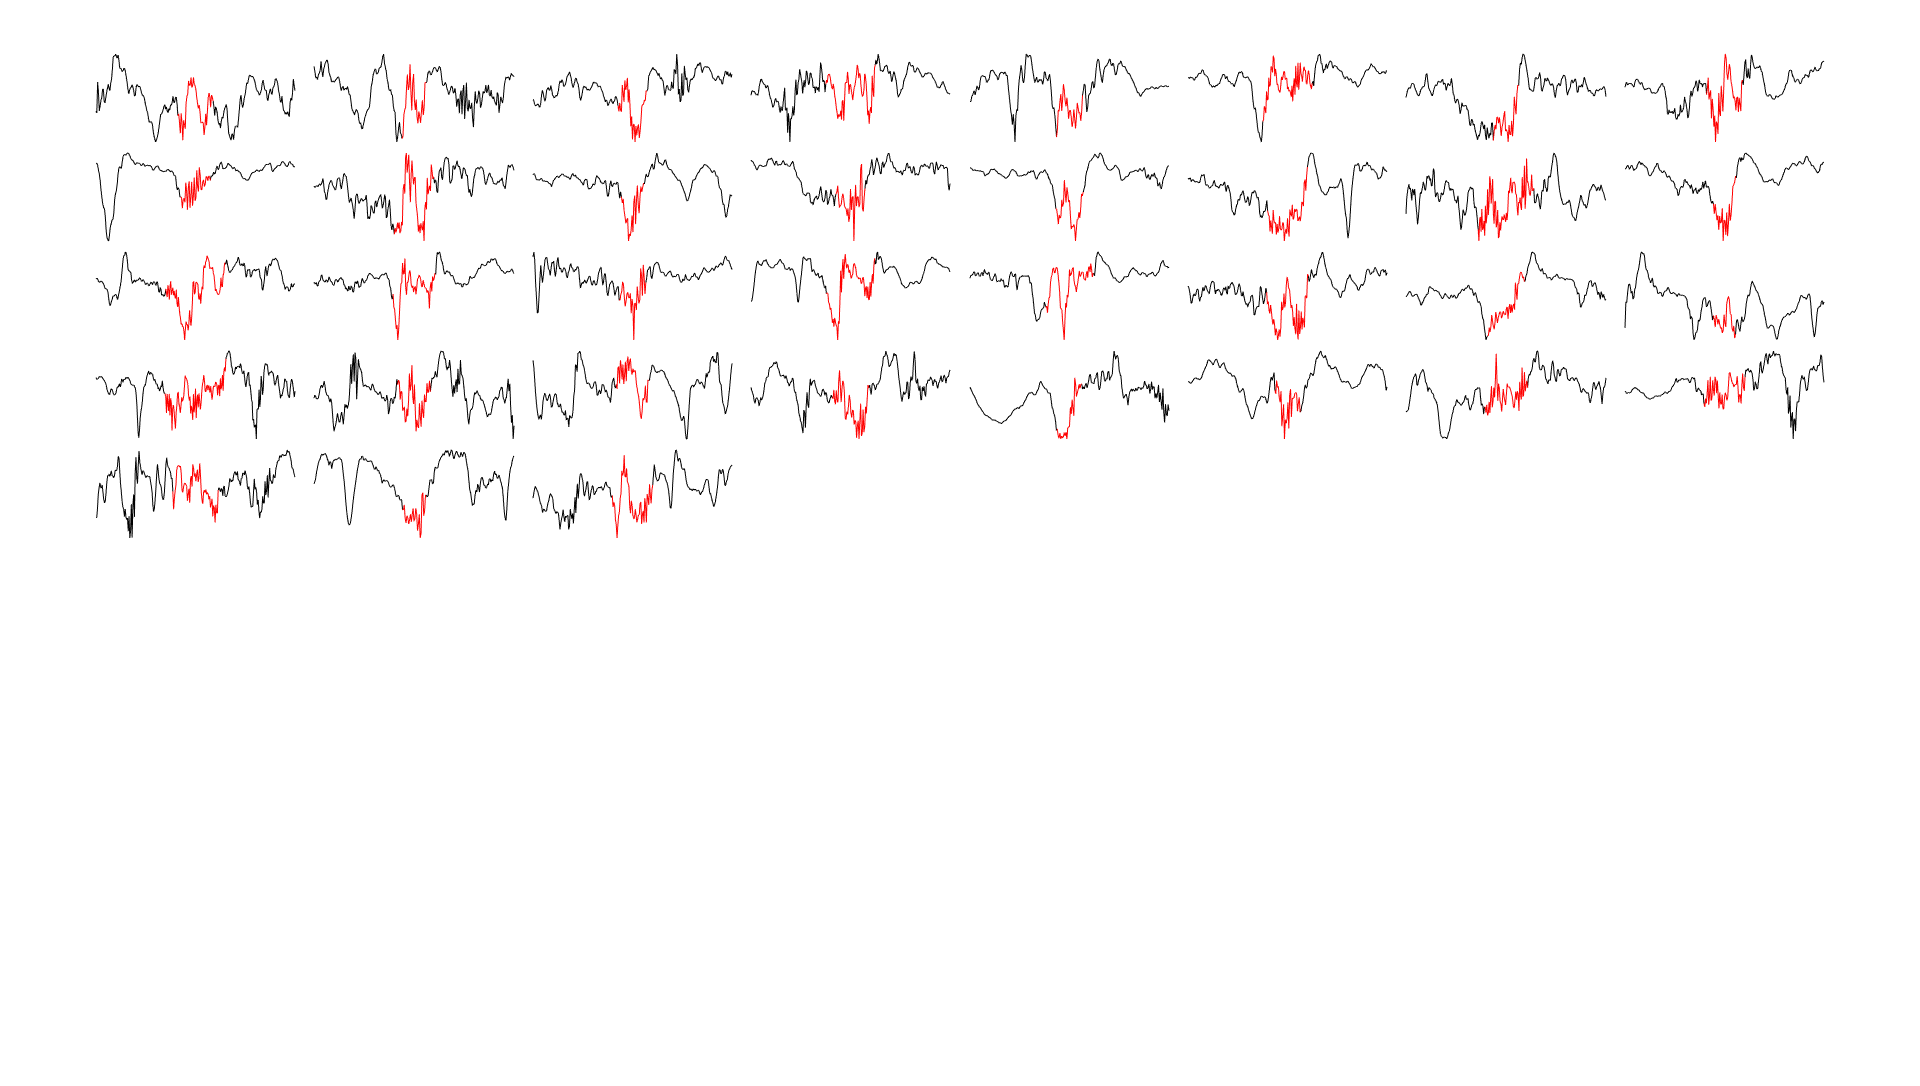

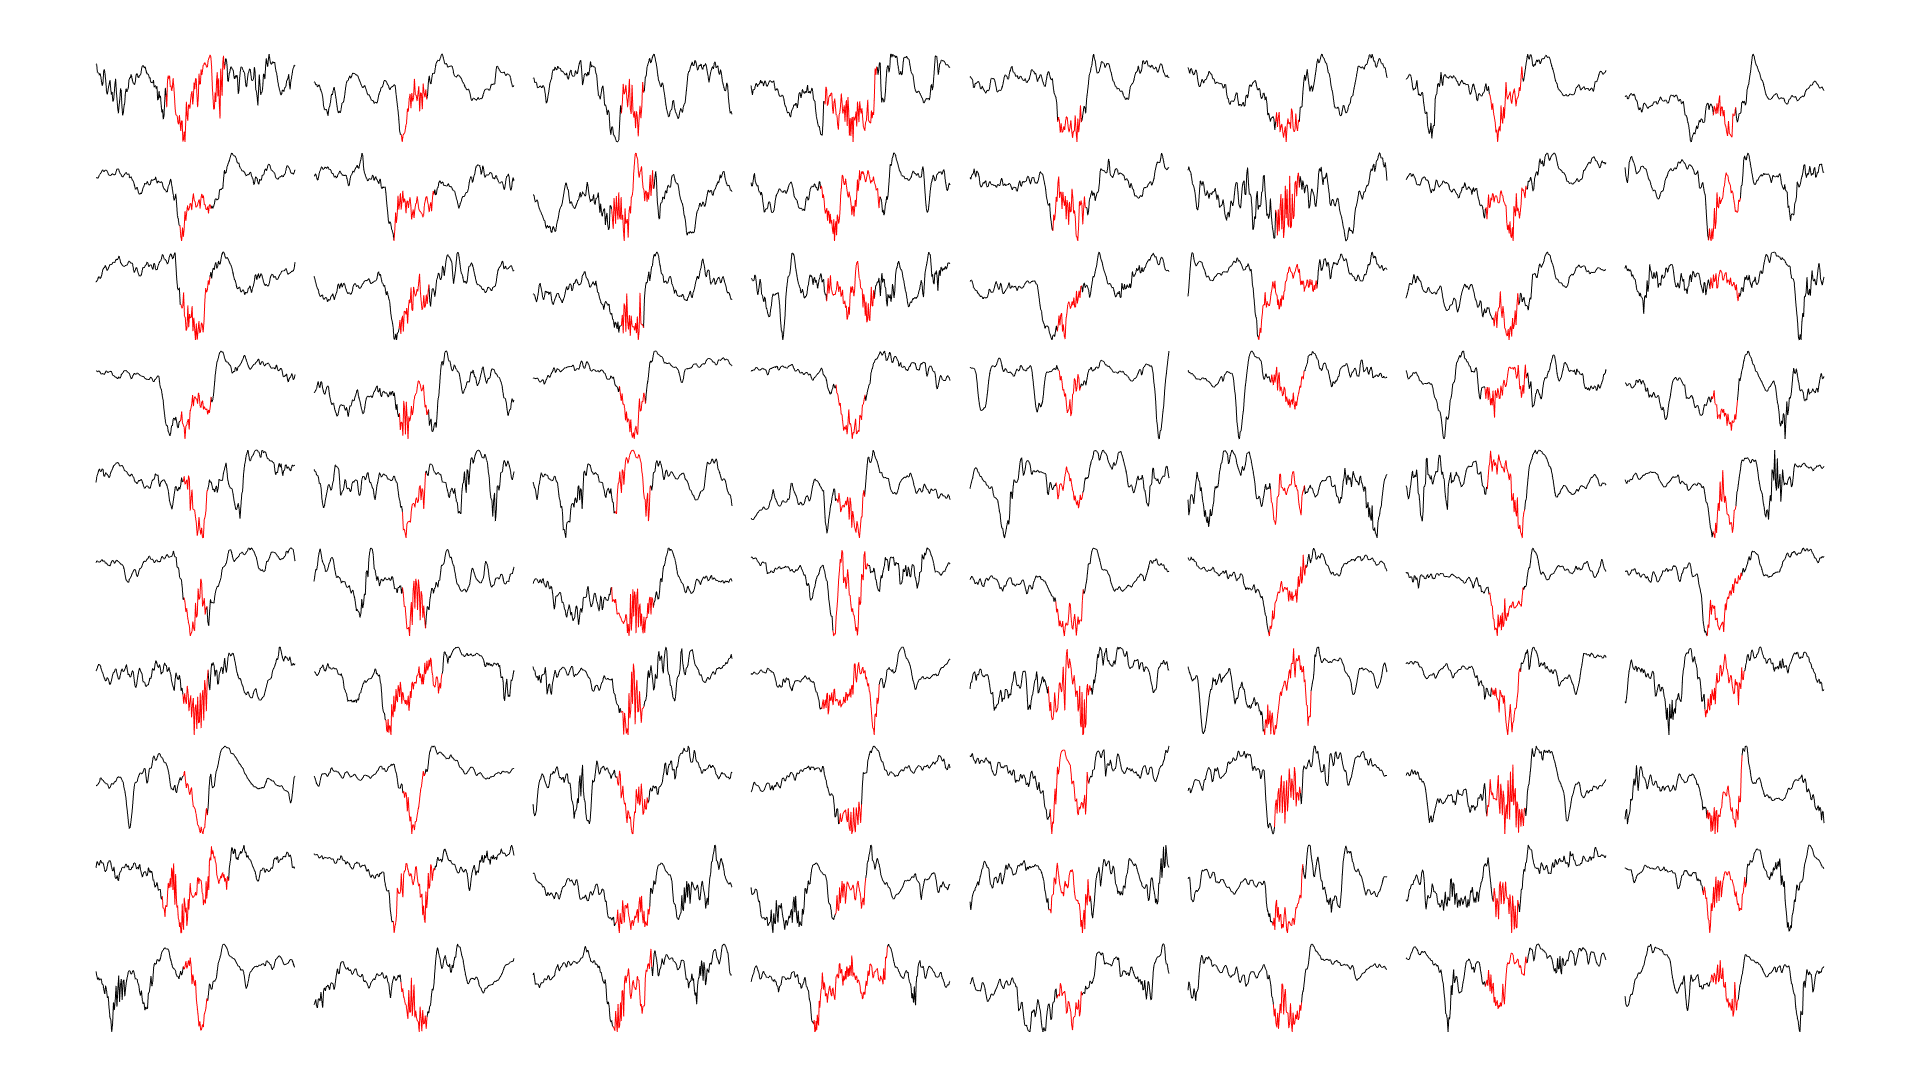

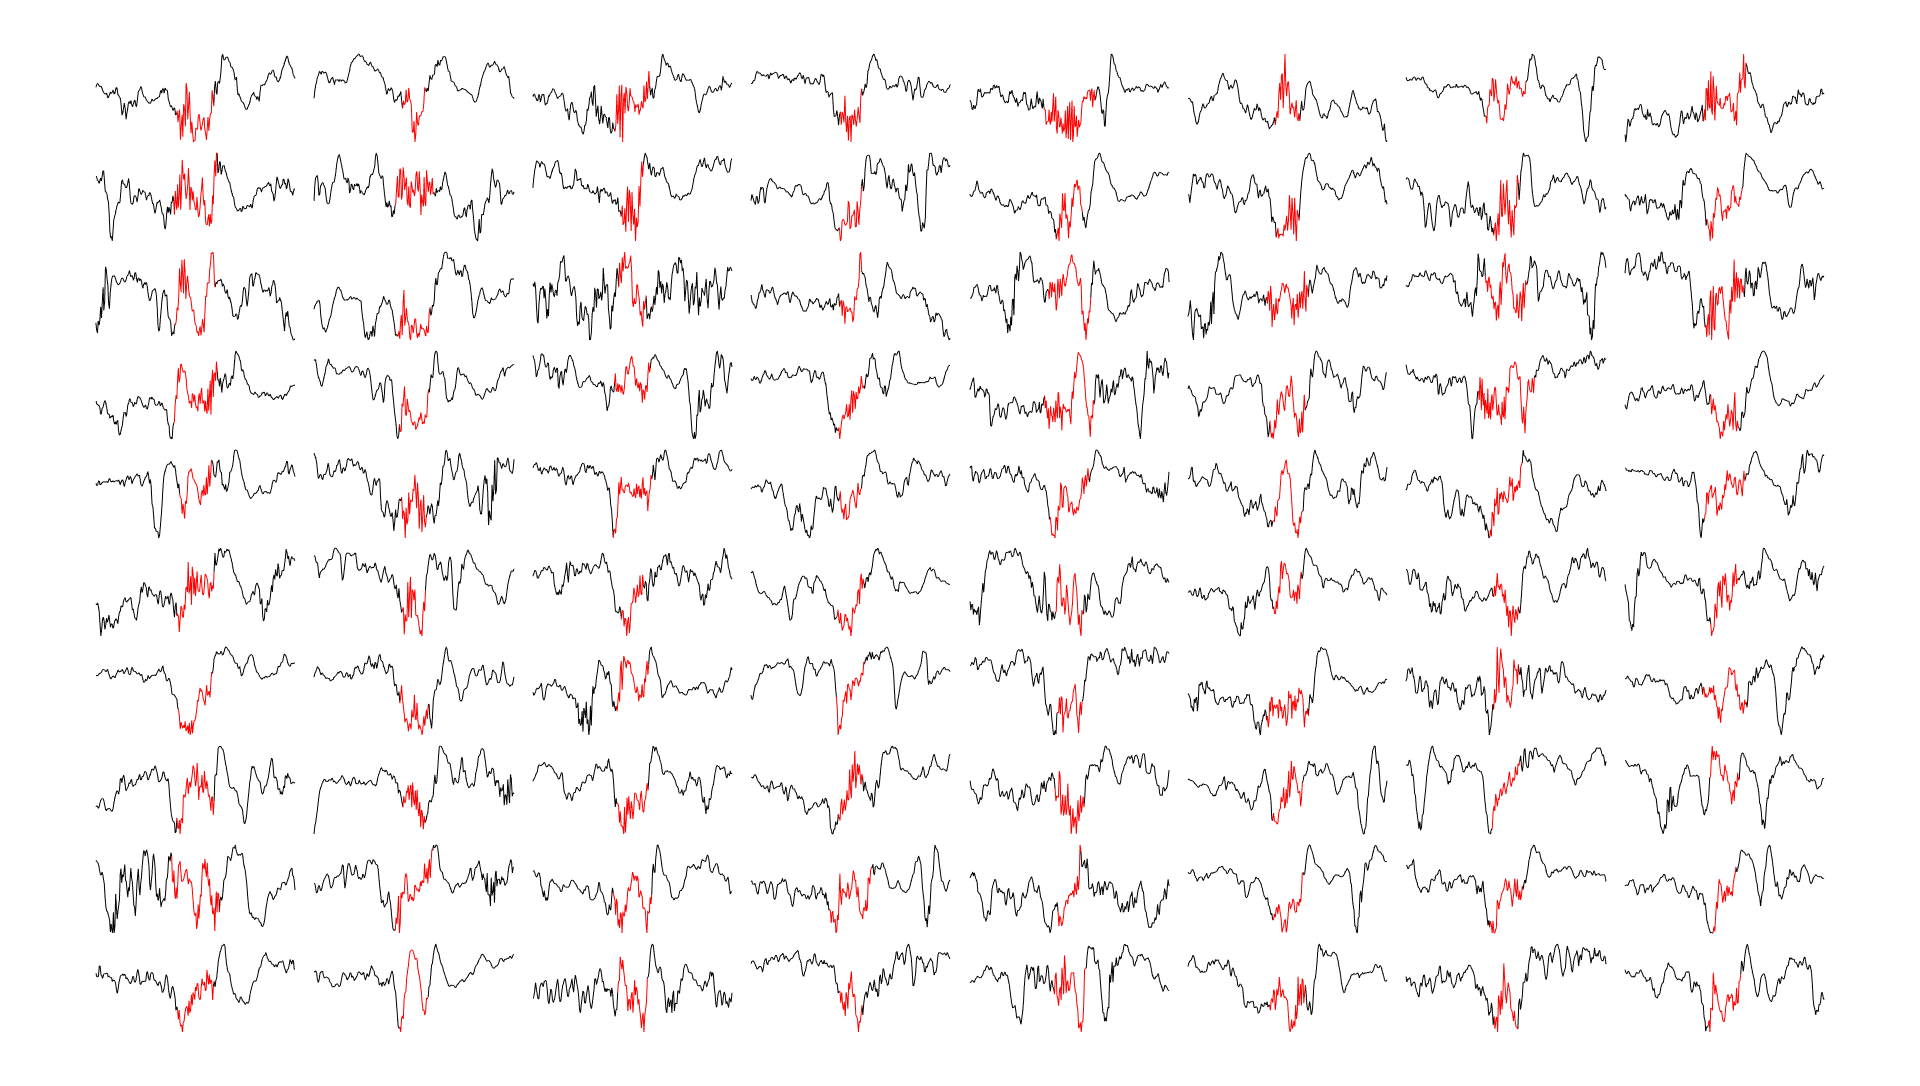

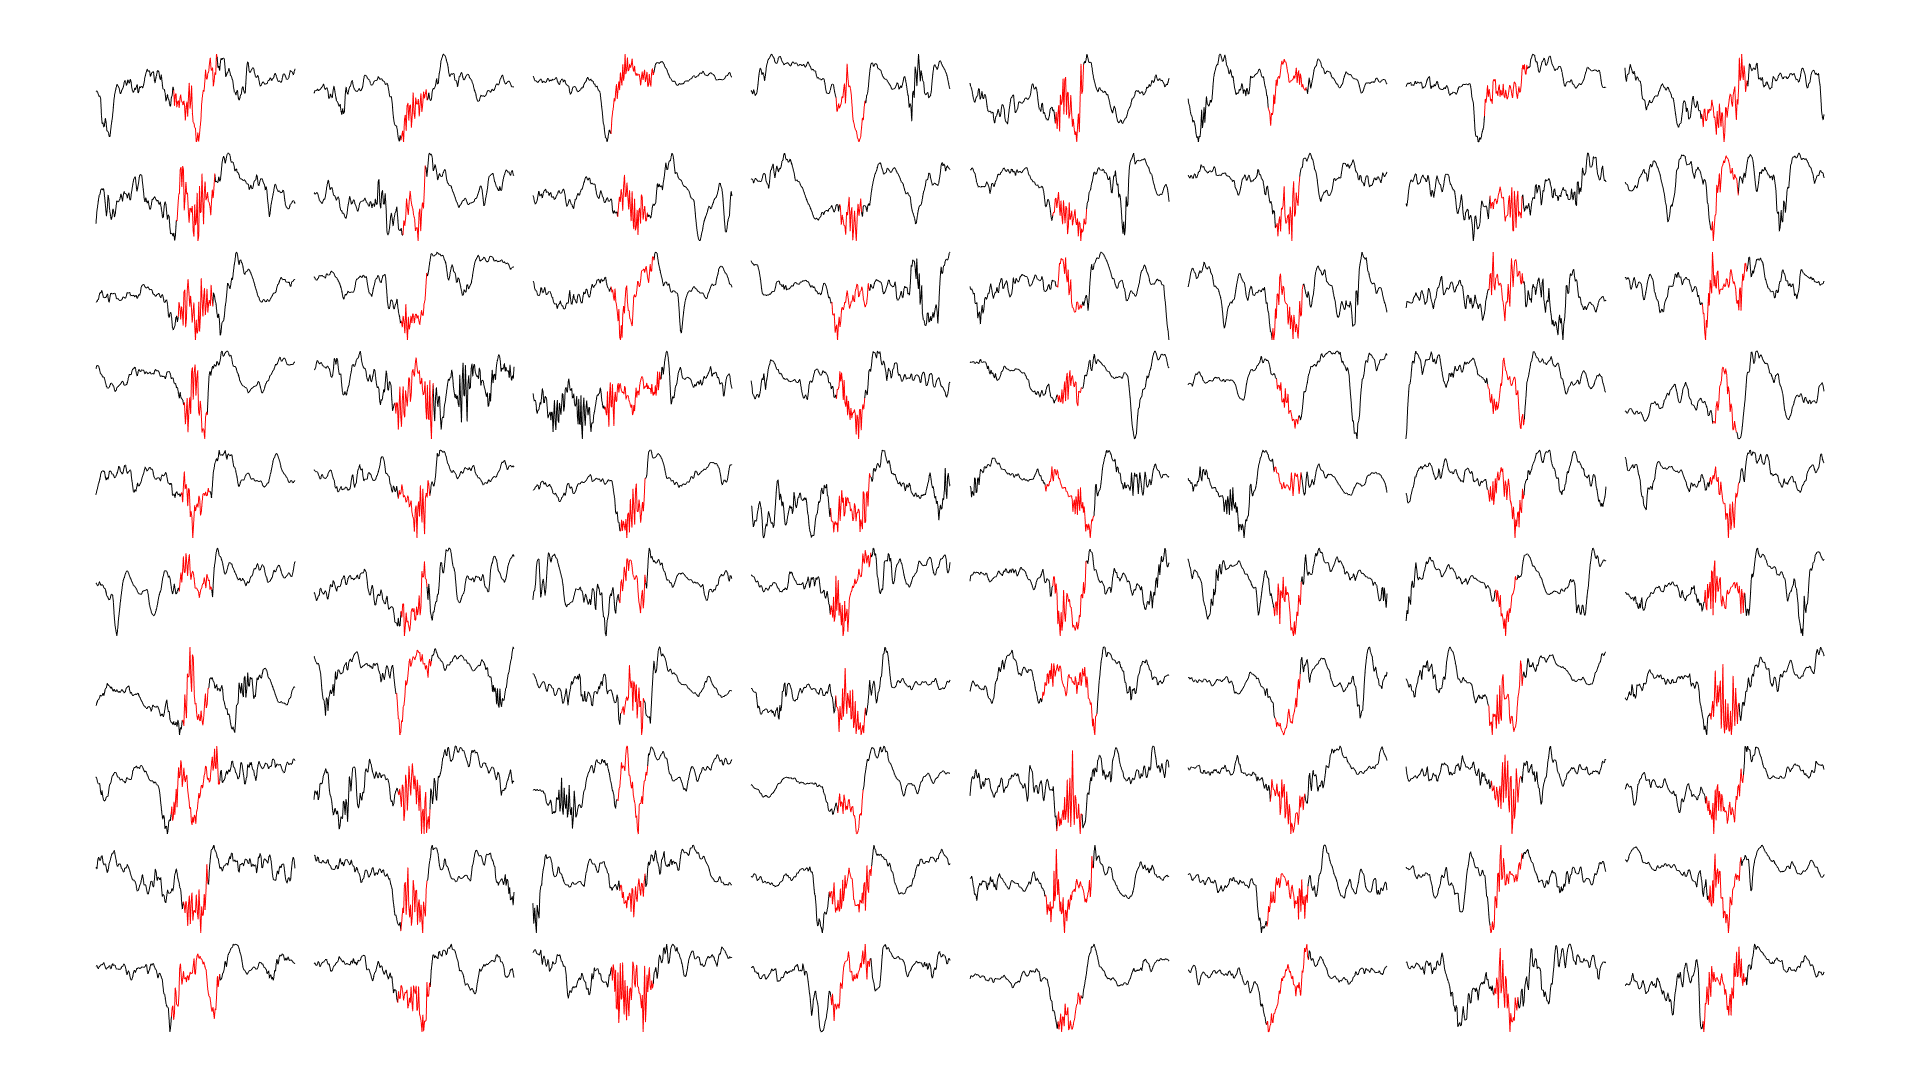

In [22]:
cfg = []; cfg.display = 'iv'; cfg.fgcol = 'r';
PlotTSDfromIV(cfg,SWR_evt,lfp);

We can also use MultiRaster() to highlight the detected events in a richer plot:

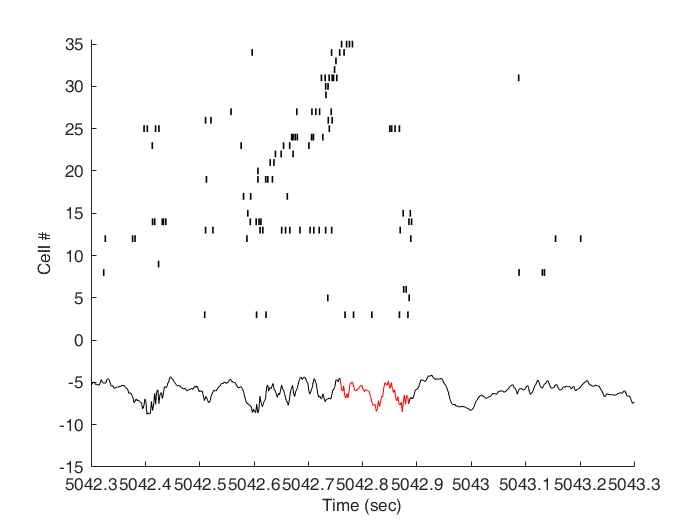

In [23]:
cfg = []; cfg.lfp = lfp; cfg.evt = SWR_evt;
MultiRaster(cfg,S_temp);
xlim([5042.3 5043.3]);

Note that you can use keyboard shortcuts to navigate between events. For instance, `c` jumps to the center event, from which `a` and `d` take you to the previous and next events respectively. `h` brings up a list of other useful keyboard shortcuts.

Inspecting a few detected SWR events should highlight the synchronous spiking that tends to accompany these events, which in some cases shows the clearly sequential order characteristic of replay (as in the above example).

☛ Optional: using the set operations for interval data listed [here](http://ctnsrv.uwaterloo.ca/vandermeerlab/doku.php?id=analysis:matlab-overview#interval_iv) use the `getMUA()` and `getLinSpd()` functions to retain only those candidates that have multi-unit activity (MUA) at least 2 SDs above the mean, and that occur when the rat is stationary.

## Scoring candidate replay events

At this point, we could use the candidate events to apply some spike-based metrics to each event in turn, and determine which events pass some significance threshold (usually relative to a shuffled distribution in which the identity of the cells and/or their spike timing is resampled). Here we take an alternative approach, which is to decode the entire session and look for intervals in which the decoded location does not jump more than a specified distance between adjacent time steps.

To do this, we use a wrapper function, `Generate_DecSeq()` which performs several of the steps covered above (linearize data, construct tuning curves, decode), plus an additional sequence detection step. There are a substantial number of parameters here, including those for decoding (time window width and step size; smoothing of tuning curves and spike trains) and for sequence detection (minimum number of active cells per time bin, maximum allowed jump distance). For now, we will use the defaults, which you can inspect by looking at the help.

In [27]:
addpath(genpath(cat(2,SET_GitHub_root,'\vandermeerlab\code-matlab\tasks\Alyssa_Tmaze\')));
out = Generate_DecSeq([]); % note, may take a couple of minutes to run!

LoadSpikes: WARNING: loading questionable cells
LoadSpikes: Loading 107 files...
LoadPos.m: 100.00% of samples tracked.
GetMatchedTrials: Equal good trials: nLtrials 9, nRTrials 9...
Linearizing...LinearizePos: linearizing data...
LinearizePos: linearizing data...
getLinSpd: calculating linear speed from position data


TSDtoIV: 1048 intervals found.
TSDtoIV: 25 intervals found.
TSDtoIV: 51 intervals found.
TSDtoIV: 20 intervals found.
TSDtoIV: 289 intervals found.
Restricting data...SelectTS: 107 ts in, 80 ts out
SelectTS: 80 ts in, 38 ts out
SelectTS: 80 ts in, 38 ts out
SelectTS: 107 ts in, 88 ts out
SelectTS: 88 ts in, 47 ts out
SelectTS: 88 ts in, 47 ts out


............................!............................!

The resulting output has a number of fields, including:
  * `P`, the decoded posterior (and `P2`, the same thing with bins not meeting thresholds removed)
  * `decode_map`, a tsd of the _maximum a posteriori_ decoded locations
  * `seq_iv`, intervals of detected sequences

In [29]:
out.expCond


ans = 

  1×2 struct array with fields:

    label
    t
    coord
    S
    decS
    linpos
    tc
    fields
    Q
    Qraw
    nNeurons
    P
    Perr
    P2
    seq_iv
    decode_map



We can plot some of the output as follows:

SelectTS: 47 ts in, 34 ts out


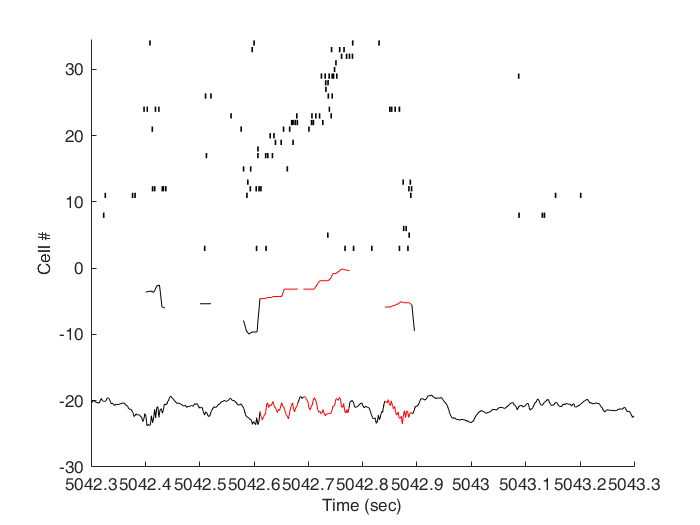

In [35]:
iCond = 2;
S_temp = SelectTS([],out.expCond(iCond).decS,out.expCond(iCond).fields.template_idx);
cfg_plot = [];
cfg_plot.lfp(1) = out.expCond(iCond).decode_map; cfg_plot.lfp(2) = lfp;
cfg_plot.evt = out.expCond(iCond).seq_iv;
MultiRaster(cfg_plot,S_temp);
xlim([5042.3 5043.3]);

The above plot shows decoded location as a broken up wiggly line, in between the spike raster at the top and the LFP at the bottom. Time bins which didn't pass all thresholds (number of cells active) are not shown. Red intervals highlight "sequences" detected by the no-jump criterion. The apparent replay event around time 5042.7 gets detected, albeit split up into two separate intervals, as does a smaller event at time 5042.9.

If you're following along in MATLAB you can scroll around (and/or use the f, l, a, d keys) to look at some other detected events. If you do, you can see a number of "theta sequences" that occur not during SWRs in the rest state, but while the animal is running along the track. Since we are interested in SWR-associated replay, we can use interval set operations to only keep decoded sequence events that overlap with the SWR events we detected earlier:

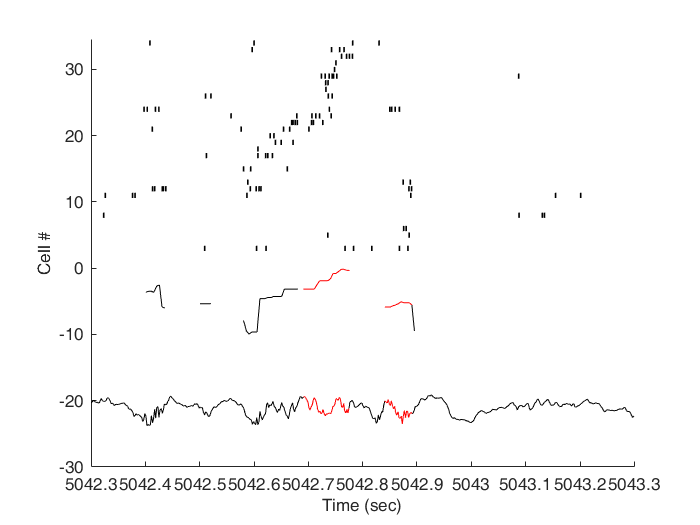

In [36]:
SWR_seq = IntersectIV([],out.expCond(iCond).seq_iv,SWR_evt);

cfg_plot.evt = SWR_seq;
MultiRaster(cfg_plot,S_temp);
xlim([5042.3 5043.3]);

Inspection of the `SWR_seq` struct reveals that there are now only 72 events left that pass the sequence criteria, as well as the SWR detection threshold. As you can see in the plot above, the first part of the replay sequence above is now left out, even though a clear SWR is visible.

☛ Change the SWR detection to set the start/end times at 2 SDs above the mean, including only events that exceed 4 SDs, and try again. You should see that now the entire replay sequence is included correctly.

Nevertheless, the above snapshot illustrates some issues. The event at 5042.4 looks like a clear SWR, but is in fact not detected. These observations motivate more sophisticated SWR detection methods, such as those based on an adaptive threshold; alternatively, we can use a different criterion, such as the subject being stationary, to rule out false positives from theta sequences.

So far, we have analyzed _left_ and _right_ data separately (as different elements in the `expCond` variable). However, it is possible that some events meet the criteria for both, either because they occur (partially) on the central stem, or because of some similarity in how the left and right arms are encoded.

☛ Use the interval set functions to create `left_only` and `right_only` iv variables in which events that meet both the left and right criteria are removed. What is the final count of left and right events?

## Exercises and mini-projects

(cognitive)
  * In this session, the rat chose to go left and right an equal number of times. Is there a relationship, in time, between the rat's choice and the content of replay? For instance, does replay content follow the animal's previous choice, or instead predict the animal's upcoming choice?
  * Replay can be both forward and backward. Is there a difference in what part of the track these different directions depict? In where the animal is when they occur, and how far into the session the animal is?
  * Do replay events contain trial-unique ("episodic") information?
  * Is there structure in the distribution of start and end points of replay events when mapped onto the track?
  
(methodology)
  * A methodological concern in the interpretation of replay data is that our ability to decode, say, left and right parts of the track aren't equal. This could occur, for instance, because by chance we don't sample the same number of cells on the left and right. Can any bias in replay content in this session be explained based on the cross-validated decoding error on actual running data?
  * How does the final replay content depend on various parameters of the analysis? To which is it most or least sensitive?
  * How can we define a chance level for (1) individual replay events detected, and (2) the overall distribution?
  
(neurophysiology)
  * How far in advance can the occurrence of a SWR event be predicted from spiking data?
  * Can the content of replay be predicted from the "sequence-ness" of theta sequences, as we would predict if spike-timing dependent plasticity (STDP) underlies the formation of a memory trace which is subsequently expressed as replay?

## Further reading

TBC